**DATA LOADING AND PREPROCESSING**

In [1]:
#Import Pandas
import pandas as pd

# Read the CSV file
df = pd.read_csv('/stock_price.csv')

# Display the first few rows
print(df.head())

# Check for data types and missing values
print(df.info())

# Summary statistics
print(df.describe())


          日付け     終値     始値     高値     安値      出来高   変化率 %
0  2024-08-01  156.3  159.3  159.4  156.1   79.15M  -2.56%
1  2024-07-31  160.4  158.2  160.7  158.1  173.91M   1.07%
2  2024-07-30  158.7  158.8  159.2  158.0  138.14M  -0.63%
3  2024-07-29  159.7  158.7  160.2  158.4  126.28M   1.14%
4  2024-07-26  157.9  159.3  159.6  157.9  155.08M  -0.13%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9202 entries, 0 to 9201
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   日付け     9202 non-null   object 
 1   終値      9202 non-null   float64
 2   始値      9202 non-null   float64
 3   高値      9202 non-null   float64
 4   安値      9202 non-null   float64
 5   出来高     9202 non-null   object 
 6   変化率 %   9202 non-null   object 
dtypes: float64(4), object(3)
memory usage: 503.4+ KB
None
                終値           始値           高値           安値
count  9202.000000  9202.000000  9202.000000  9202.000000
mean     92.180961    92.256183 

In [2]:
reference = {"Date": "日付け", "Close": "終値", "Open": "始値", "High": "高値", "Low": "安値", "Volume": "出来高", "Return": "変化率 %"} #Converting the Japanese columns to English for convenience

In [3]:
# Convert Date column to datetime format
df['日付け'] = pd.to_datetime(df['日付け'], format='%Y-%m-%d')

# Set '日付け' as the index
df.set_index('日付け', inplace=True)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20516 (\N{CJK UNIFIED IDEOGRAPH-5024}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32066 (\N{CJK UNIFIED IDEOGRAPH-7D42}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23433 (\N{CJK UNIFIED IDEOGRAPH-5B89}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


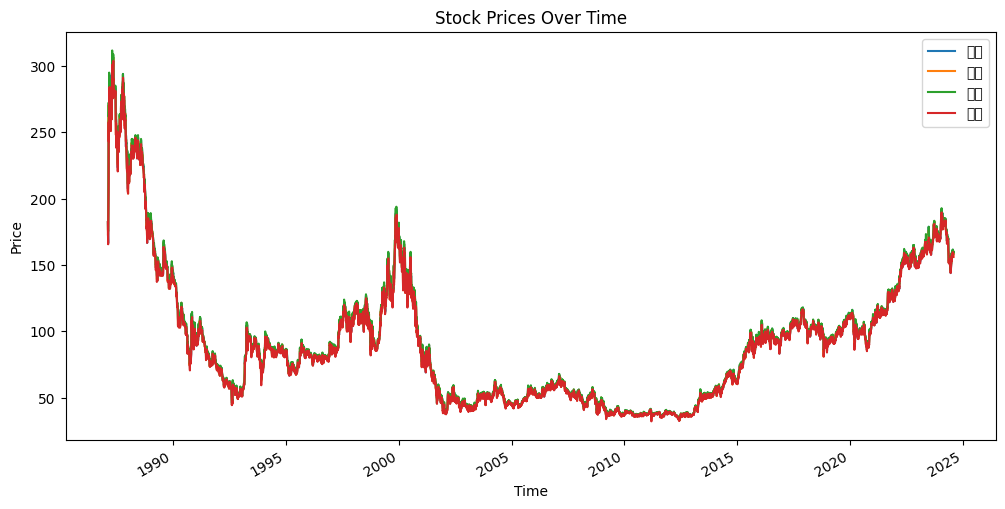

In [4]:
import matplotlib.pyplot as plt

# Plotting the Open, Close, High, Low values
df[['始値', '終値', '高値', '安値']].plot(figsize=(12,6))
plt.title('Stock Prices Over Time')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show()


In [5]:
#removing the 'M' from the Volume column and the '%' from the Return Column
for i in range(9202):
    df['出来高'][i] = float(df['出来高'][i][:-1])
    df[reference["Return"]][i] = float(str(df[reference["Return"]][i])[:-1])

Streaming output truncated to the last 5000 lines.
<ipython-input-5-cab05d2a84e3>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['出来高'][i] = float(df['出来高'][i][:-1])
<ipython-input-5-cab05d2a84e3>:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single 

**MODEL TRAINING**

In [6]:
#Import Necessary libraries
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
from keras.callbacks import EarlyStopping


In [7]:
#Normalization on Train Data
sc = MinMaxScaler(feature_range=(0, 1))
trainData = sc.fit_transform(df[[reference['Close']]].values[:9000])
trainData.shape

(9000, 1)

In [8]:
#Normalization of Test Data
testData = sc.transform(df[[reference['Close']]].values[9000:])
testData.shape

(202, 1)

In [9]:
#Taking the History of previous 60 days as the Input and the Next day's Stock Price as Output (Lagged Observations)
X_train = []
Y_train = []
for i in range(60, 9000):
    X_train.append(trainData[i-60:i])
    Y_train.append(trainData[i])
X_test = []
Y_test = []
for i in range(60, 202):
    X_test.append(testData[i-60:i])
    Y_test.append(testData[i])


In [10]:
X_train, Y_train = np.array(X_train), np.array(Y_train) #Converting the Train Data to NumPy arrays

In [11]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #Adding the Feature Dimension (Here, it is only one)
X_train.shape

(8940, 60, 1)

In [12]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build the model
model = Sequential()

model.add(GRU(32, return_sequences=True, input_shape=(X_train.shape[1], 1)))

model.add(GRU(32, return_sequences=True))

model.add(GRU(32))
model.add(Dropout(0.2))

model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 60, 32)              │           3,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 60, 32)              │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,065 (62.75 KB)

 Trainable params: 16,065 (62.75 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.fit(X_train, Y_train, epochs=100, batch_size=16,
          validation_split=0.2,  # Use 20% of training data as validation set
          callbacks=[early_stopping])


Epoch 1/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0053 - val_loss: 3.7061e-04
Epoch 2/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 8.1120e-04 - val_loss: 2.9748e-04
Epoch 3/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 6.9636e-04 - val_loss: 2.3780e-04
Epoch 4/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 5.2343e-04 - val_loss: 1.8097e-04
Epoch 5/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 4.6115e-04 - val_loss: 4.9793e-04
Epoch 6/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 4.5490e-04 - val_loss: 1.9405e-04
Epoch 7/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 4.4117e-04 - val_loss: 2.5549e-04
Epoch 8/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.9814e-04 - val_loss: 0.0013
Epoch 9/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3.9813e-04 - val_loss: 1.7394e-04
Epoch 10/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 3.6949e-04 - val_loss: 1.5931e-04
Epoch 11/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 4s 1

**MODEL TESTING**

In [15]:
X_test = np.array(X_test) #Converting the Test Data into an array


In [16]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) # Converting it into a 3D Tensor
X_test.shape

(142, 60, 1)

In [17]:
y_pred = model.predict(X_test) # Predicting on Test Data

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [18]:
#Calculate the R squared score as the evaluation Metric
from sklearn.metrics import r2_score

r2_score(Y_test, y_pred)

0.9257632493972778

In [19]:
model.save('GRU_stock_price_predictions.keras') # Save the Model

**DE-NORMALIZING THE VALUES FOR PLOTTING**

In [20]:
predicted_price = sc.inverse_transform(y_pred)

In [21]:
actual_price = sc.inverse_transform(Y_test)

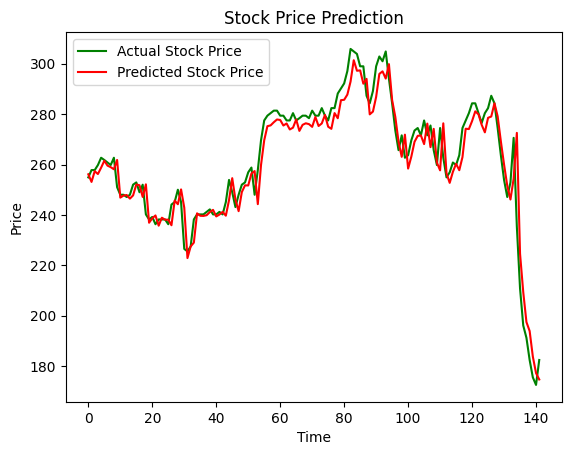

In [22]:
#Plotting the Actual and Predicted Stock Prices for better Visualisation
plt.plot(actual_price, color='green', label='Actual Stock Price')
plt.plot(predicted_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()
plt.show()

**LOAD MODEL AND RUN ON CUSTOM VALUES**

In [23]:
from keras.models import load_model

model = load_model('GRU_stock_price_predictions.keras')  #Load the Model

In [ ]:
#Uncomment the Following Code to Give Prediction
'''
input_array = np.array(input) #Pass the input array (60 values)
y_pred = model.predict(input_array)
'''